# Feature Extraction

In [ ]:
pip install nilearn

In [ ]:
from nilearn import datasets
from nilearn import input_data

In [ ]:
#Getting 264 MNI Co-ordinates corresponding to 264 ROIs from Power et. al(2011)
power = datasets.fetch_coords_power_2011()
print('Power atlas comes with {0}.'.format(power.keys()))

In [ ]:
import numpy as np

coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

print('Stacked power coordinates in array of shape {0}.'.format(coords.shape))

In [ ]:
from sklearn import preprocessing, covariance
myScaler = preprocessing.StandardScaler()

In [ ]:
#Calculating the Functional Connectivity Matrix for each bold file and stacking them together in "data" variable for further Machine Learning
for i in range(1,10,1):
  for j in range(1,11,1):
    try:
      if i==6 and j==8:
        continue
      path = "s"+str(i)+"/ses"+str(j)+"_filtered_func_data.nii.gz"

      spheres_masker = input_data.NiftiSpheresMasker(seeds=coords, smoothing_fwhm=6, radius=10.,allow_overlap=True, detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2)
      timeseries = np.array(spheres_masker.fit_transform(path), dtype=np.float64)
      timeseries = myScaler.fit_transform(timeseries)
      timeseries = covariance.empirical_covariance(timeseries)
      timeseries = covariance.shrunk_covariance(timeseries, shrinkage=0.8)

  #print('time series has {0} samples'.format(timeseries.shape[0]))
      try:
        from sklearn.covariance import GraphicalLassoCV
      except ImportError:
      # for Scitkit-Learn < v0.20.0
        from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

      covariance_estimator = GraphicalLassoCV(cv=3, verbose=1)
      covariance_estimator.fit(timeseries)
      matrix = covariance_estimator.covariance_
      np.save("sub_"+str(i)+"ses_"+str(j)+".npy", matrix)
      d=matrix[np.triu_indices(264, k = 1)]
      d = d.reshape(1,34716)
      d = np.concatenate((d,[[i]]),axis=1)
      if i==1 and j==1:
        data = d
      else:
        data = np.concatenate((data,d))
    except:
      continue

#print('Covariance matrix has shape {0}.'.format(matrix.shape))
np.save("data.npy",data)


In [ ]:
#Making the last column LabelEncoded
import numpy as np
data = np.load("data.npy")
#For Midnight Scan Club Data below line is required, for HCP Data it is not
data[:,data.shape[1]-1] = data[:,data.shape[1]-1]-1

In [ ]:
data[:,data.shape[1]-1]

In [ ]:
#Separating the features and labels
X = data[:,:-1]
y = data[:, data.shape[1]-1]

In [ ]:
X.shape

In [ ]:
#Generating the Train and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=None)

In [ ]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# ANOVA Feature Selection and Linear SVM Pipeline

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline


In [ ]:
#k=1600 for Midnight Scan Club and 5200 for HCP Data
anova_filter = SelectKBest(f_classif, k=1600)
clf = LinearSVC()
anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)

In [ ]:
#Saving the trained Model
import pickle
pickle.dump(anova_svm, open('anova_svm.sav', 'wb'))

In [ ]:
#Printing the Metrics
from sklearn.metrics import classification_report

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))


#Saving the metrics as csv file
import pandas
report = classification_report(y_test, y_pred, output_dict=True)
df = pandas.DataFrame(report).transpose()
df.to_csv('report.csv')

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

In [ ]:
#Drawing a graph for accuracy vs features
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
x=[]
y=[]

#Selecting top k features

for i in range(100,34717,100):
  x.append(i)
  anova_filter = SelectKBest(f_classif, k=i)
  clf = LinearSVC()
  anova_svm_plt = make_pipeline(anova_filter, clf)
  anova_svm_plt.fit(X_train, y_train)
  y_pred = anova_svm_plt.predict(X_test)
  y.append(accuracy_score(y_test, y_pred))
  print(i)
  np.save("x.npy",np.array(x))
  np.save("y.npy", np.array(y))
#Printing the Metrics
#from sklearn.metrics import classification_report, accuracy_score
#y_pred = anova_svm_plt.predict(X_test)
#print(classification_report(y_test, y_pred))
#print("Accuracy is: ", accuracy_score(y_test, y_pred))

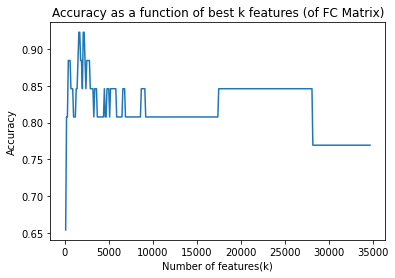

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.xlabel('Number of features(k)')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of best k features (of FC Matrix)')
plt.savefig("output_100.jpg")
plt.show()
#Below plot for Midnight Scan Club Data

# Leave One Out Cross Validation

In [ ]:
import numpy as np
data = np.load("data.npy")

In [ ]:
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


X, y = data[:, :-1], data[:, -1]
#print(X.shape, y.shape)
# create loocv procedure
cv = LeaveOneOut()
# create model
#model = RandomForestClassifier(random_state=1)

#ANOVA Feature Selection and Linear SVM Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC


anova_filter = SelectKBest(f_classif, k=1600)
clf = LinearSVC()
model = make_pipeline(StandardScaler(),anova_filter, clf)
  #model.fit(X_train, y_train)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
np.save("mean_scores_final_1600k.npy",np.array(mean(scores)))
np.save("std_scores_final_1600k.npy",np.array(std(scores)))

In [ ]:
#Calculating the index for best accuracy
np.argmax(y)

15

# Permutation Test

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import permutation_test_score, LeaveOneOut



data = np.load("data.npy")
X, y = data[:, :-1], data[:, -1]

f = [1735, 5200]
for i in f:
 

 n_uncorrelated_features = i
 rng = np.random.RandomState(seed=0)
 # Use same number of samples as in iris and 2200 features
 X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))


 cv = LeaveOneOut()
 


 anova_filter = SelectKBest(f_classif, k=i)
 clf = LinearSVC()
 model = make_pipeline(StandardScaler(),anova_filter, clf)


 score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(model, X, y, scoring="accuracy", cv=cv, n_permutations=1000)

 score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(model, X_rand, y, scoring="accuracy", cv=cv, n_permutations=1000)

 np.save("score_iris"+str(i)+".npy",score_iris)
 np.save("perm_score_iris"+str(i)+".npy",perm_score_iris)
 np.save("pvalue_iris"+str(i)+".npy",pvalue_iris)
 np.save("score_rand"+str(i)+".npy",score_rand)
 np.save("perm_scores_rand"+str(i)+".npy",perm_scores_rand)
 np.save("pvalue_rand"+str(i)+".npy",pvalue_rand)



 #Original Data
 import matplotlib.pyplot as plt

 fig, ax = plt.subplots()

 ax.hist(perm_scores_iris, bins=20, density=True)
 ax.axvline(score_iris, ls='--', color='r')
 score_label = (f"Score on original\ndata: {score_iris:.2f}\n"
               f"(p-value: {pvalue_iris:.3f})")
 ax.text(0.7, 260, score_label, fontsize=12)
 ax.set_xlabel("Accuracy score")
 _ = ax.set_ylabel("Probability")
 plt.savefig("Permutation_Original_"+str(i))
 plt.show()



 #Random Data
 fig, ax = plt.subplots()

 ax.hist(perm_scores_rand, bins=20, density=True)
 ax.set_xlim(0.13)
 ax.axvline(score_rand, ls='--', color='r')
 score_label = (f"Score on original\ndata: {score_rand:.2f}\n"
               f"(p-value: {pvalue_rand:.3f})")
 ax.text(0.14, 125, score_label, fontsize=12)
 ax.set_xlabel("Accuracy score")
 ax.set_ylabel("Probability")
 plt.savefig("Permutation_Random"+str(i))
 plt.show()





# ROC Curve

In [ ]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
#ANOVA Feature Selection and Linear SVM Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [ ]:
# Import some data to play with
data = np.load("data.npy")
X, y = data[:, :-1], data[:, -1]



In [ ]:
# Binarize the output
n_classes = 50
arr = np.arange(n_classes)
#y = label_binarize(y, classes=arr)

"""
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
"""
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=None)
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:

# Learn to predict each class against the other
anova_filter = SelectKBest(f_classif, k=1735)
clf = LinearSVC()
classifier = make_pipeline(anova_filter, clf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
#classifier.fit(X_train, y_train)


In [ ]:
import pickle
pickle.dump(classifier, open('classifier.sav', 'wb'))

In [ ]:
# Compute ROC curve and ROC area for each class

cclf = CalibratedClassifierCV(base_estimator=make_pipeline(anova_filter, clf),method='sigmoid', cv=None)
cclf.fit(X_train, y_train)
import pickle
pickle.dump(cclf, open('cclf.sav', 'wb'))
y_train = label_binarize(y_train, classes=arr)
y_test = label_binarize(y_test, classes=arr)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2


plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
"""
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','chocolate','lime','lawngreen','slategrey','sandybrown','gray','silver','rosybrown','navajowhite','turquoise','paleturquoise','darkcyan','cornflowerblue','indigo','brown','darkred'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i],color=color, lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i])
             )
 """
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC Curve for 9 Subjects (or 9 classes) from Midnight Scan Club Data')
plt.title('ROC Curve for 50 Subjects (or 50 classes) from HCP Data')
plt.legend(loc="lower right")
plt.savefig("roc1.jpg")
plt.show()



y_prob = cclf.predict_proba(X_test)

#macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
#weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
#print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
 #     "(weighted by prevalence)"
  #    .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))


# Pearson Correlation Based Classification

In [ ]:
import numpy as np
data = np.load("data.npy")
X, y = data[:, :-1], data[:, -1]
corr = np.corrcoef(X)


In [ ]:
list1 = [102614,  113215,	122317,	131722,	140824,	151223,	160729,	171734,	180735,	192237,	201515,	211821,	257946,	334635,	392447,	481143,	559053,	604537,	677968,	743248,	818455,	885975,	962058,
102715	,113316,	122418,	131823,	140925,	151324,	160830,	172029,	180836,	192439,	201717,	211922,	263032,	336841,	392750,	481951,	559457,	609143,	679568,	744553,	818859,	886674,	965367,
102816	,113417,	122519,	131924]

list2 = [100307,115017,115724,130316,144832,158843,159340,175237,202820,206828,257845,579665,654754,680957,786569,871762,894774,100408,115219,130013,130417,144933,159138,175035,191437,206525,
256540,361941,579867,680250,724446,788674,894067,932554,100610,115320,130114,144731,145127,159239,175136,191841,206727,257542,365343,580044,680452,784565,792766,894673]



list1_as_set = set(list1)

intersection = list1_as_set.intersection(list2)


intersection_as_list = list(intersection)

import numpy as np
print(intersection_as_list)
np.array(list1).shape
#np.array(list2).shape